In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Dropout, Convolution2D,MaxPool2D, ZeroPadding2D,BatchNormalization,Flatten,Dense,InputLayer
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
nvidia-smi 

In [4]:
path = '/content/gdrive/My Drive/fkpd/'
traindf = pd.read_csv(path+'training.csv')
testdf =  pd.read_csv(path+'test.csv')

In [5]:
traindf.shape,testdf.shape

((7049, 31), (1783, 2))

In [6]:
traindf.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [7]:
def load_images(image_data):
  images = []
  for idx, sample in image_data.iterrows():
      image = np.array(sample['Image'].split(' '), dtype=int)
      image = np.reshape(image, (96,96,1))
      images.append(image)
  images = np.array(images)/255.
  return images

def load_keypoints(keypoint_data):
  keypoint_data = keypoint_data.drop('Image',axis = 1)
  keypoint_features = []
  for idx, sample_keypoints in keypoint_data.iterrows():
    keypoint_features.append(sample_keypoints)
  keypoint_features = np.array(keypoint_features, dtype = 'float')
  return keypoint_features
  
def plot_sample(image, keypoint, axis, title):
  image = image.reshape(96,96)
  axis.imshow(image, cmap='gray')
  axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
  plt.title(title)

In [8]:
train_img_nonull = load_images(traindf[traindf.isnull().sum(axis=1) == 0])
train_kp_nonull = load_keypoints(traindf[traindf.isnull().sum(axis=1) == 0])
train_img_null = load_images(traindf[traindf.isnull().sum(axis=1) != 0])
train_kp_null = load_keypoints(traindf[traindf.isnull().sum(axis=1) != 0])
test_img = load_images(testdf)

In [10]:
train_img_nonull.shape,train_kp_nonull.shape,train_img_null.shape,train_kp_null.shape,test_img.shape

((2140, 96, 96, 1),
 (2140, 30),
 (4909, 96, 96, 1),
 (4909, 30),
 (1783, 96, 96, 1))

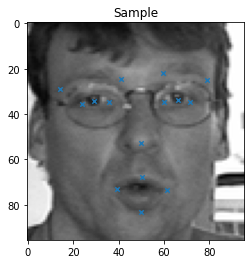

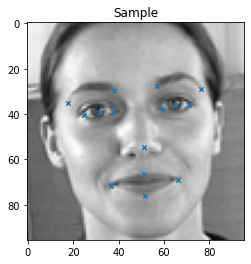

In [11]:
fig, axis = plt.subplots()
plot_sample(train_img_nonull[24],train_kp_nonull[24],axis,'Sample')
fig, axis = plt.subplots()
plot_sample(train_img_nonull[23],train_kp_nonull[23],axis,'Sample')

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from keras import backend
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [13]:
def get_model(n_layer = 2):
  model = Sequential()
  model.add(InputLayer(input_shape=[96,96,1]),)
  for i in range(0,n_layer):

    model.add(Convolution2D(2**(5+i), (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(Convolution2D(2**(5+i), (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

  model.add(Convolution2D(2**(n_layer), (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Convolution2D(2**(i), (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(30))
  model.compile(optimizer='adam', loss='mean_squared_error',metrics=[rmse,'mae'])

  return(model)

In [14]:
step_1model = get_model(5)
step_1model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0

In [15]:
!nvidia-smi

Mon Aug 10 05:18:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |    423MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)
hist = step_1model.fit(train_img_nonull,train_kp_nonull,validation_split = 0.2,epochs = 1000,batch_size = 10,callbacks=[monitor],verbose=2)

Epoch 1/1000
172/172 - 3s - loss: 289.5170 - rmse: 10.0877 - mae: 8.6808 - val_loss: 222.1659 - val_rmse: 14.8330 - val_mae: 13.4631
Epoch 2/1000
172/172 - 2s - loss: 11.2939 - rmse: 3.2220 - mae: 2.5811 - val_loss: 20.9916 - val_rmse: 4.3679 - val_mae: 3.4782
Epoch 3/1000
172/172 - 2s - loss: 10.7140 - rmse: 3.1431 - mae: 2.5206 - val_loss: 16.4711 - val_rmse: 3.8725 - val_mae: 3.0948
Epoch 4/1000
172/172 - 2s - loss: 9.9952 - rmse: 3.0229 - mae: 2.4252 - val_loss: 21.4544 - val_rmse: 4.4938 - val_mae: 3.6240
Epoch 5/1000
172/172 - 2s - loss: 9.2034 - rmse: 2.9004 - mae: 2.3315 - val_loss: 19.8392 - val_rmse: 4.3224 - val_mae: 3.4498
Epoch 6/1000
172/172 - 2s - loss: 8.7804 - rmse: 2.8363 - mae: 2.2755 - val_loss: 18.4039 - val_rmse: 4.1353 - val_mae: 3.3359
Epoch 7/1000
172/172 - 2s - loss: 8.2054 - rmse: 2.7324 - mae: 2.1889 - val_loss: 13.9473 - val_rmse: 3.5647 - val_mae: 2.8175
Epoch 8/1000
172/172 - 2s - loss: 7.4098 - rmse: 2.6019 - mae: 2.0856 - val_loss: 14.3069 - val_rmse: 3

In [17]:
print('at epoch: ',hist.history['val_rmse'].index( min(hist.history['val_rmse'])),' Min Val_rmse is ',np.sqrt(min(hist.history['val_rmse'])))

at epoch:  110  Min Val_rmse is  1.389145052916578


In [26]:
def get_kf(X,y,n_layers,epochs,n_splits=5):
  kf = KFold(n_splits=n_splits, random_state=24, shuffle=True)
  train_rmse_list = []
  test_rmse_list = []
  for train_index, test_index in kf.split(X):
    model =  get_model(n_layers)
    print('split')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train,epochs = epochs,batch_size = 10,verbose=False)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_rmse_list.append(mean_squared_error(y_train,train_pred))
    test_rmse_list.append(mean_squared_error(y_test,test_pred))
  return(train_rmse_list,test_rmse_list)

In [27]:
train_rmse_list,test_rmse_list= get_kf(X=train_img_nonull,y=train_kp_nonull,n_layers=5,epochs=110)

split
split
split
split
split


In [28]:
print(train_rmse_list)
print(test_rmse_list)
print('KFold: \n Train RMSE:',np.mean(test_rmse_list),' Test RMSE:',np.mean(test_rmse_list))

[1.0885163946114071, 1.0591233200425034, 0.9124236145376037, 1.5569757346235094, 0.9585900448062785]
[1.9698161004693873, 2.05606801631077, 1.8440700102180867, 2.415114820374718, 1.68538778692641]
KFold: 
 Train RMSE: 1.9940913468598744  Test RMSE: 1.9940913468598744


In [30]:
pred_train_img_null = step_1model.predict(train_img_null) 
pd.DataFrame(pred_train_img_null).to_csv(path+'1.99_Step1_pred.csv',index=False)

In [31]:
train_kp_null = np.array(pd.DataFrame(train_kp_null).fillna(pd.DataFrame(pred_train_img_null)) )

In [32]:
train_img_tot = np.append(train_img_nonull,train_img_null,axis=0)
train_kp_tot  = np.append(train_kp_nonull,train_kp_null,axis=0)
train_img_tot.shape,train_kp_tot.shape

((7049, 96, 96, 1), (7049, 30))

In [33]:
model_final = get_model(5)
model_final.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_84 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_85 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 48, 48, 32)       

In [34]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, 
        verbose=1, mode='auto', restore_best_weights=True)
hist = model_final.fit(train_img_tot,train_kp_tot,validation_split = 0.2,epochs = 1000,batch_size = 10,callbacks=[monitor],verbose=2)

Epoch 1/1000
564/564 - 9s - loss: 98.8950 - rmse: 5.6525 - mae: 4.7086 - val_loss: 12.1926 - val_rmse: 3.2671 - val_mae: 2.6284
Epoch 2/1000
564/564 - 8s - loss: 11.1529 - rmse: 3.1038 - mae: 2.4457 - val_loss: 6.9395 - val_rmse: 2.4683 - val_mae: 1.9171
Epoch 3/1000
564/564 - 8s - loss: 8.3579 - rmse: 2.6699 - mae: 2.1019 - val_loss: 16.2045 - val_rmse: 3.9143 - val_mae: 3.2496
Epoch 4/1000
564/564 - 8s - loss: 7.1583 - rmse: 2.4570 - mae: 1.9410 - val_loss: 3.9426 - val_rmse: 1.7811 - val_mae: 1.3690
Epoch 5/1000
564/564 - 8s - loss: 6.4394 - rmse: 2.3212 - mae: 1.8375 - val_loss: 4.0761 - val_rmse: 1.8058 - val_mae: 1.3603
Epoch 6/1000
564/564 - 8s - loss: 5.8524 - rmse: 2.1991 - mae: 1.7360 - val_loss: 4.0330 - val_rmse: 1.7872 - val_mae: 1.3675
Epoch 7/1000
564/564 - 8s - loss: 5.4900 - rmse: 2.1207 - mae: 1.6790 - val_loss: 8.1745 - val_rmse: 2.7177 - val_mae: 2.1945
Epoch 8/1000
564/564 - 8s - loss: 5.4034 - rmse: 2.0996 - mae: 1.6651 - val_loss: 2.9390 - val_rmse: 1.4902 - val_

In [35]:
print('at epoch: ',hist.history['val_rmse'].index( min(hist.history['val_rmse'])),' Min Val_rmse is ',min(hist.history['val_rmse'])
,'& Dev RMSE: ',hist.history['rmse'][hist.history['val_rmse'].index( min(hist.history['val_rmse']))] )

at epoch:  109  Min Val_rmse is  1.1226298809051514 & Dev RMSE:  1.350439429283142


In [36]:
train_rmse_list,test_rmse_list= get_kf(X=train_img_tot,y=train_kp_tot,n_layers=5,epochs=109)

split
split
split
split
split


In [1]:
print(train_rmse_list)
print(test_rmse_list)
print('KFold: \n Train RMSE:',np.mean(test_rmse_list),' Test RMSE:',np.mean(test_rmse_list))

In [1]:
final_pred = model_final.predict(test_img)

In [ ]:
pd.DataFrame(final_pred).to_csv(path+'sri_copy_FKPD_sub.csv',index=False)

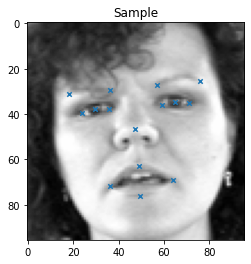

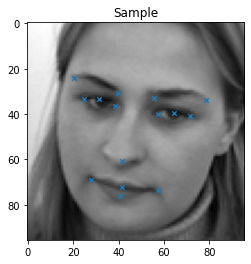

In [ ]:
fig, axis = plt.subplots()
plot_sample(test_img[24],final_pred[24],axis,'Sample')
fig, axis = plt.subplots()
plot_sample(test_img[23],final_pred[23],axis,'Sample')

In [ ]:
idlookup_data =  pd.read_csv(path+'IdLookupTable.csv')
feature_names = list(idlookup_data['FeatureName'])
row_ids = list(idlookup_data['RowId'])
image_ids = list(idlookup_data['ImageId']-1)
feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))

predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(final_pred[x][y])

In [ ]:
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv(path+'1.99_sub.csv',index=False)